# Задача классификации

Бизнес-задача: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

Основная цель проекта: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import optuna
import warnings
warnings.filterwarnings('ignore')

c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Первичная обработка данных

In [2]:
# Прочитаем датасет
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
# Смотрим количество пропусков по столбцам
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [5]:
# Изучим содержимое столбца balance
df['balance'].head(10)

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
5           0  $ 
6       830,00 $ 
7       545,00 $ 
8         1,00 $ 
9             NaN
Name: balance, dtype: object

In [6]:
# Создадим функцию для преобразования содержимого столбца balance в число типа float
def to_float(x):
    x = str(x)
    x = x.replace(' ', '').replace(',00', '').replace('$', '')
    return x

In [7]:
# Преобразуем столбец
df['balance'] = df['balance'].apply(to_float).astype('float')

In [8]:
# Заменом пропуски на медианное значение по столбцу
df = df.fillna({'balance':df['balance'].median()})

In [9]:
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [10]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [11]:
# Изучим категориальные признаки на предмет пропущенных данных
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [12]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [13]:
# Заменим попуски модальными значениями
df['job'] = df['job'].apply(lambda x: 'management' if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: 'secondary' if x == 'unknown' else x)

In [14]:
# Создадим функцию для выявения выбросов в признаках по межквартильному методу
def outliers_iqr(data, feature):
    x = data[feature]
    quart1, quart3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quart3-quart1
    low_bound = quart1-(iqr*1.5)
    up_bound = quart3+(iqr*1.5)
    print(f'low bound: {low_bound}, up bound: {up_bound}')
    outliers = data[(x<low_bound)|(x>up_bound)]
    cleaned = data[(x>=low_bound)&(x<=up_bound)]
    return outliers, cleaned

In [15]:
# Очистим датасет от выбросов по признаку balance
outliers, cleaned = outliers_iqr(df, 'balance')

low bound: -2241.0, up bound: 4063.0


### Разведывательный анализ

In [16]:
# Посмотрим соотношение классов целевой переменной
cleaned['deposit'].value_counts(normalize=True)

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

Text(0, 0.5, 'Количество')

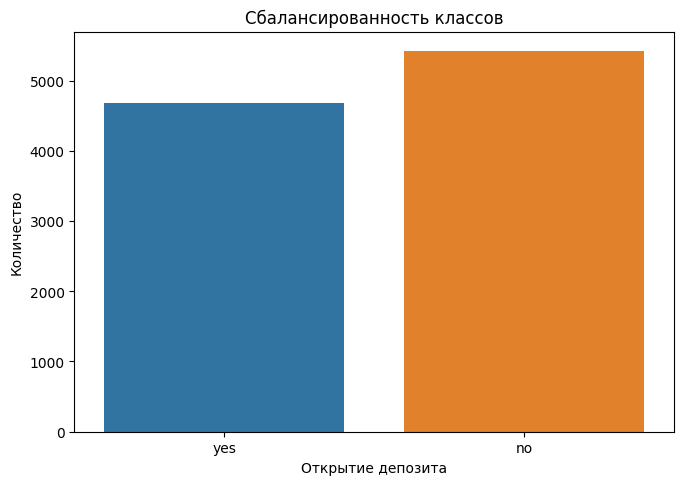

In [17]:
# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
sns.countplot(cleaned, x='deposit', ax=ax)
ax.set_title('Сбалансированность классов')
ax.set_xlabel('Открытие депозита')
ax.set_ylabel('Количество')

Явного дисбаланса не наблюдается

Рассчитаем описательные статистики для числовых и категориальных признаков

In [18]:
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [19]:
cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Визуализируем связи между признаками

1. Успешность маркетинговой кампании (открытие депозита) по месяцам

Text(0, 0.5, 'Количество')

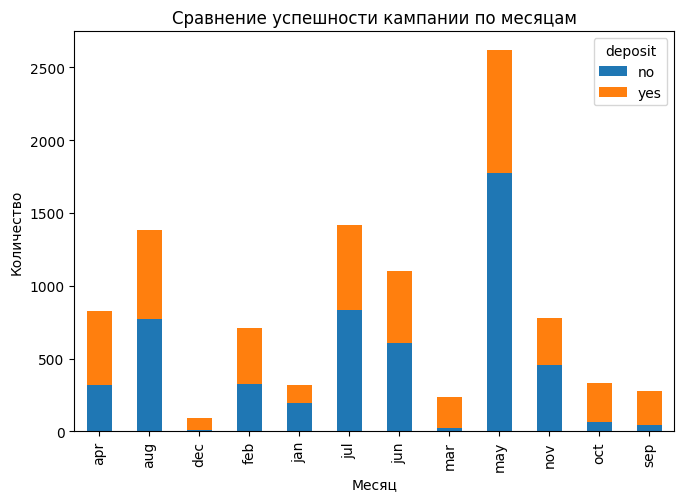

In [20]:
# Группируем данные по признаку месяца с количественным соотношением по таргету
types = cleaned.groupby("month")['deposit'].value_counts(normalize=False).unstack()

# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
types.plot(kind='bar', stacked='True', ax=ax)
ax.set_title('Сравнение успешности кампании по месяцам')
ax.set_xlabel('Месяц')
ax.set_ylabel('Количество')


Мы видим, что результаты по месяцам достаточно сильно отличаются. Месяца с наибольшим количеством клиентов, вовлеченных в маркетинговую кампанию, отличаются большим числом отказов. С другой стороны, в декабре, марте, октябре и сентябре наблюдается значительный перевес в пользу ооткрытия депозита. Это может стать важным диагностическим признаком.

2. Зависимость таргета от возраста клиента

Text(0, 0.5, 'Количество')

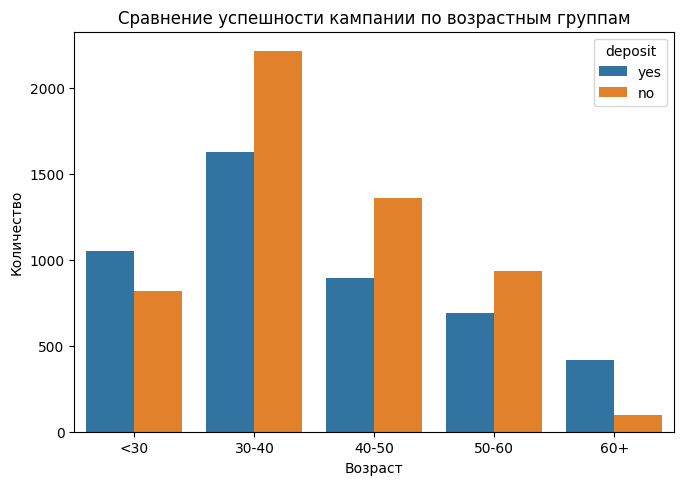

In [21]:
# Создадим признак возрастной группы
cleaned['age_group'] = pd.cut(df.age, [0,30,40,50,60,99], labels = ['<30','30-40','40-50','50-60','60+'])

# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
sns.countplot(x="age_group", hue="deposit", data=cleaned, ax=ax)
ax.set_title('Сравнение успешности кампании по возрастным группам')
ax.set_xlabel('Возраст')
ax.set_ylabel('Количество')

График показывает, что чаще всего по результатам маркетинговой кампании более склонны к открытию депозита клиенты 30-40 лет. В возрастных группах от 30 до 60 лет превалирует отрицательный результат, тогда как в группах до 30 и старше 60 лет клиенты чаще открывают депозит. Это так же указывает на связь возрастного и целевого признаков.

3. Зависимость целевого признака от семейного статуса

Text(0, 0.5, 'Семейный статус')

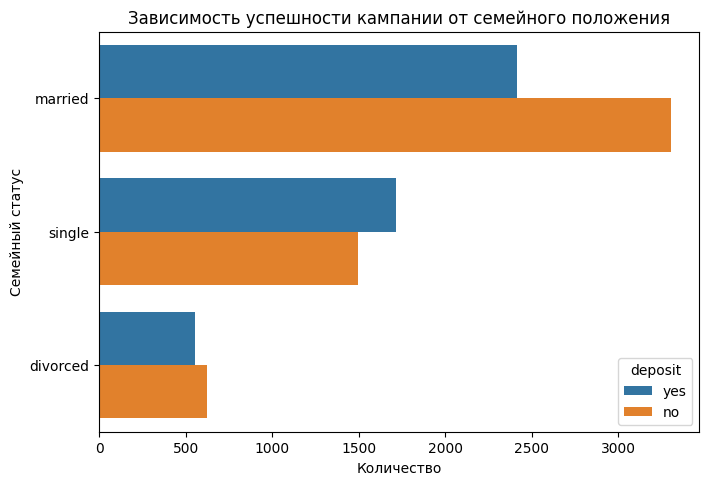

In [22]:
# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
sns.countplot(y='marital', hue='deposit', data=cleaned, ax=ax)
ax.set_title('Зависимость успешности кампании от семейного положения')
ax.set_xlabel('Количество')
ax.set_ylabel('Семейный статус')

Как видно из графика, семейное положение также влияет на вероятность успеха маркетинговой кампании. По отношению к общему числу открытых депозитов, большая часть принадлежит женатым людям. В то же время, если человек не в паре, он с большей вероятностью (пусть и незначительно) откроет счет.

4. Зависимость целевого признака от образования клиента

Text(0, 0.5, 'Уровень образования')

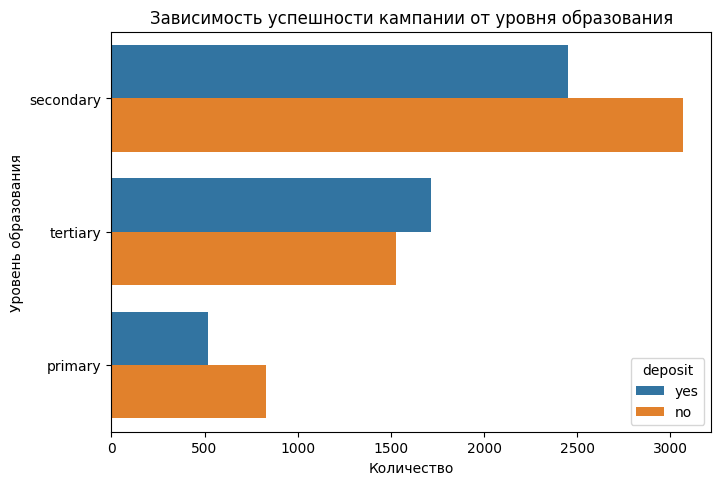

In [23]:
# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
sns.countplot(y='education', hue='deposit', data=cleaned, ax=ax)
ax.set_title('Зависимость успешности кампании от уровня образования')
ax.set_xlabel('Количество')
ax.set_ylabel('Уровень образования')

Здесь мы видим, что клиенты с начальным и средним образованием менее склонны к открытию депозита, чем люди с высшим образованием. Уровень образования тоже может пополнить ряд признаков, оказывающих прямое влияние на таргет.

5. Влияние профессиональной деятельности клиентов на целевой признак

Text(0, 0.5, 'Вид профессиональной деятельности')

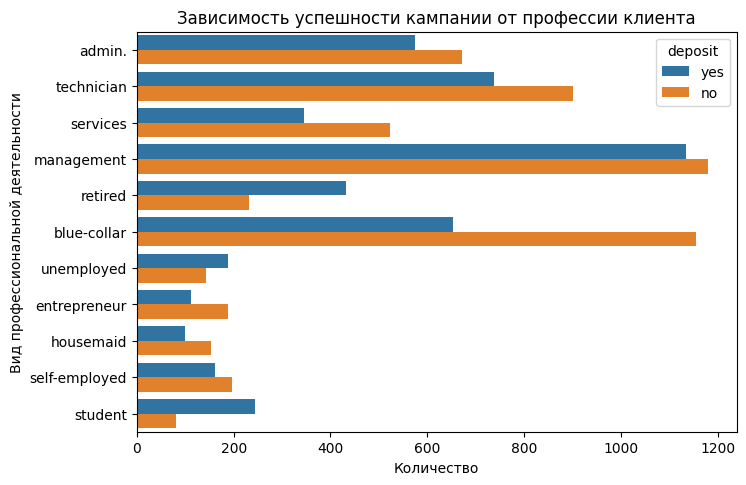

In [24]:
# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
sns.countplot(y='job', hue='deposit', data=cleaned, ax=ax)
ax.set_title('Зависимость успешности кампании от профессии клиента')
ax.set_xlabel('Количество')
ax.set_ylabel('Вид профессиональной деятельности')

Данный график показывает различное распределение таргета по профессиям. Это говорит о том, что вероятность открытия депозита клиентом отчасти зависит и от рода его деятельности. В своих группах наиболее склонны к открытию депозита студенты, пенсионеры и безработные, как это ни странно.
Но от общего количества открытых счетов в результате маркетинговой кампании их, конечно же, не так много.

### Преобразование данных

Кодирование признаков

In [25]:
# Создаем экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодируем признак уровня образования
cleaned['education'] = lab_enc.fit_transform(cleaned['education'])
# Кодируем признак возрастной группы
cleaned['age_group'] = lab_enc.fit_transform(cleaned['age_group'])

In [26]:
# Преобразуем бинарные переменные deposit, housing, default и loan
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 1 if x=='yes' else 0)
cleaned['housing'] = cleaned['housing'].apply(lambda x: 1 if x=='yes' else 0)
cleaned['default'] = cleaned['default'].apply(lambda x: 1 if x=='yes' else 0)
cleaned['loan'] = cleaned['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [27]:
cleaned.describe()


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,age_group
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,1.187036,0.016428,807.653538,0.481148,0.137853,15.590302,368.742603,2.517170,51.319644,0.816230,0.463236,1.437308
std,11.734931,0.647373,0.127119,994.151966,0.499669,0.344762,8.441510,346.651524,2.707159,109.644179,2.243795,0.498671,1.489490
min,18.000000,0.000000,0.000000,-2049.000000,0.000000,0.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,32.000000,1.000000,0.000000,95.000000,0.000000,0.000000,8.000000,137.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
50%,38.000000,1.000000,0.000000,445.000000,0.000000,0.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,0.000000,1.000000
75%,48.000000,2.000000,0.000000,1227.000000,1.000000,0.000000,22.000000,490.000000,3.000000,2.000000,1.000000,1.000000,2.000000
max,95.000000,2.000000,1.000000,4063.000000,1.000000,1.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,1.000000,4.000000


In [28]:
cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


In [29]:
# Создадим дамми-переменные для признаков job, marital, contact, month и poutcome
data = pd.get_dummies(cleaned, columns=['job','marital','contact','month','poutcome'])

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

Все признаки теперь представлены числовым форматом, оценим их с точки зрения корреляции на наличие мультиколлинеарности.

Text(0.5, 1.0, 'Тепловая карта корреляции признаков')

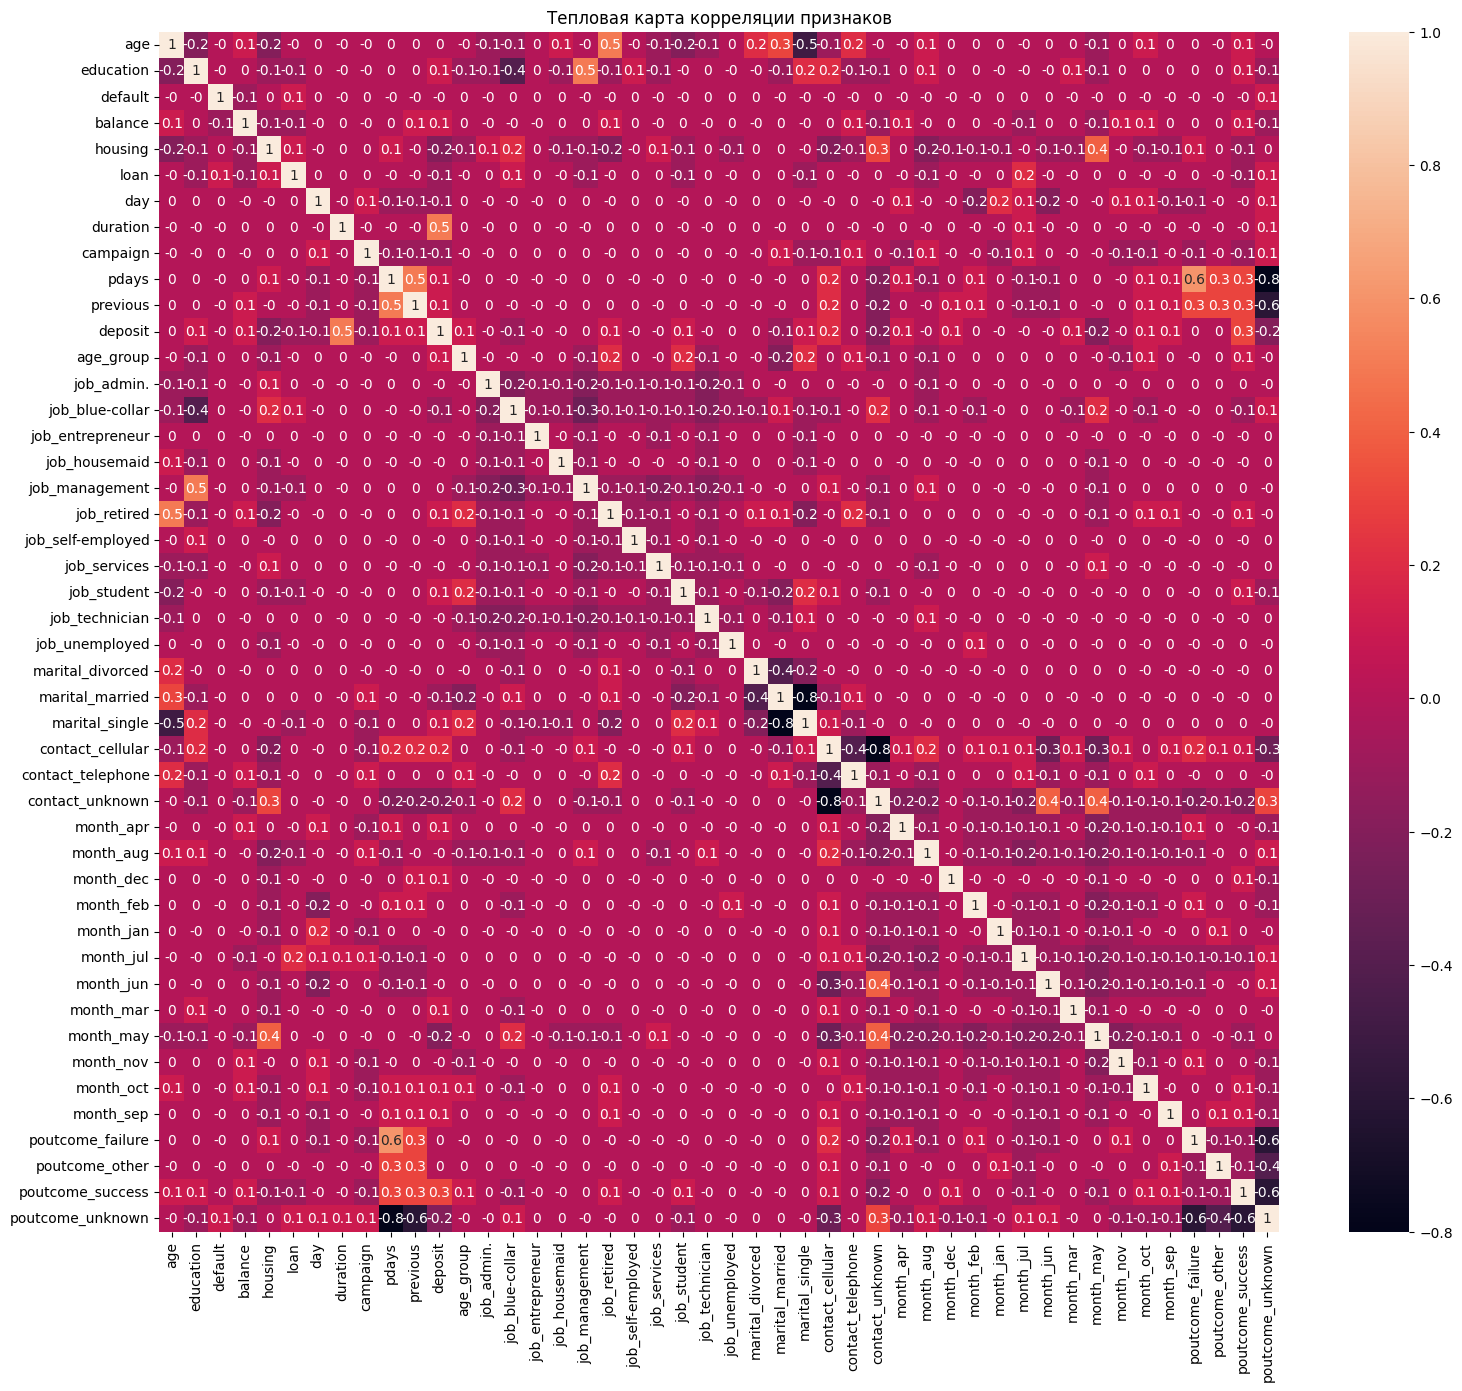

In [31]:
# Строим график
fig = plt.figure(figsize=(14, 12))
ax = fig.add_axes((1,1,1,1))
sns.heatmap(round(data.corr(), 1), ax=ax, annot=True)
ax.set_title('Тепловая карта корреляции признаков')

Как мы видим, ряд признаков имеют сильную обратную зависимость, удалим их из датасета

In [32]:
# Удаляем столбцы с мультиколлинеарностью
data = data.drop(['poutcome_unknown', 'contact_unknown', 'marital_single'], axis=1)

Сравним тепловые карты

Text(0.5, 1.0, 'Тепловая карта корреляции признаков')

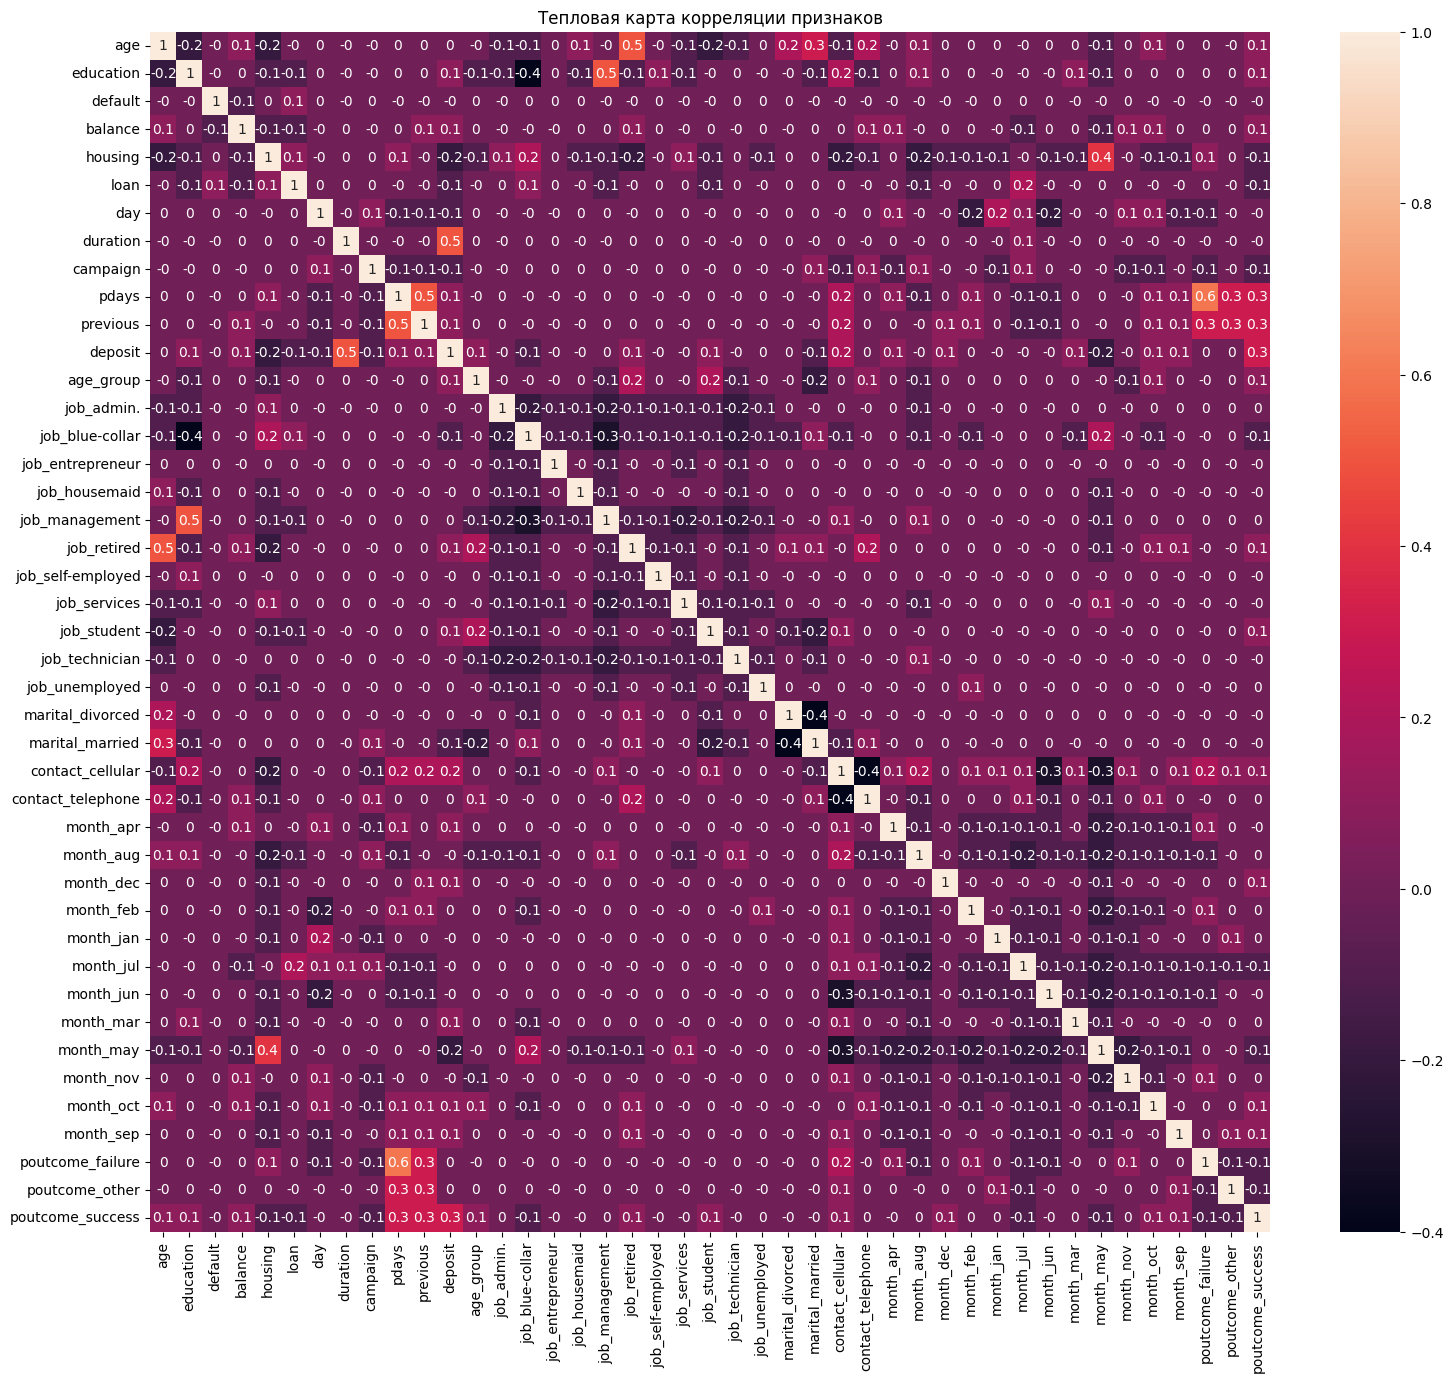

In [33]:
# Строим график
fig = plt.figure(figsize=(14, 12))
ax = fig.add_axes((1,1,1,1))
sns.heatmap(round(data.corr(), 1), ax=ax, annot=True)
ax.set_title('Тепловая карта корреляции признаков')

Разделим данные на тренировочную и тестовую выборки

In [34]:
# Выделяем целевую переменную
X = data.drop(['deposit'], axis=1)
y = data['deposit']
# Делим данные в соотношении 30/70 со стратификацией по таргету
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 36, test_size = 0.3)

In [35]:
# Отберем 15 признаков с помощью SelectKBest()
selector = SelectKBest(f_classif, k=15)
# Обучаем на тренировочных данных
selector.fit(X_train, y_train)
feat_imp = selector.get_feature_names_out()
# Преобразуем
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

In [36]:
# Нормализуем данные с помощью MinMaxScaler()
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_sel)                          
X_train_scaled = scaler.transform(X_train_sel)   
X_test_scaled = scaler.transform(X_test_sel)      

### Решение задачи классификации

##### Логистическая регрессия

В качестве baseline будем использвать модель логистической регрессии с параметрами по умолчанию

In [37]:
# Создаем модель логистической регрессии
log_reg = linear_model.LogisticRegression(
    random_state=36, 
    max_iter=1000
    )
# Обучаем модель и делаем предсказание
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
# Вычисляем метрики
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1627
           1       0.84      0.75      0.79      1405

    accuracy                           0.82      3032
   macro avg       0.82      0.81      0.81      3032
weighted avg       0.82      0.82      0.82      3032



Качество модели будем оценивать по взвешенному среднему F1

In [38]:
# Произведем подбор гиперпараметров с помощью GridSearchCV
# Задаем пространство параметров
parameters =  {
    'penalty': ['l1', 'l2', 'none'], 
    'solver':['sag', 'lbfgs']
    }
# Создаем и обучаем модель
model = GridSearchCV(
    linear_model.LogisticRegression(random_state=36), 
    parameters,
    cv=3, 
    scoring=('f1'), 
    return_train_score=True
    )

model.fit(X_train_scaled, y_train)
print(f'Best params: {model.best_params_}')
log_reg_f1 = round(model.best_score_, 2)
print(f'F1 score: {log_reg_f1}')

Best params: {'penalty': 'none', 'solver': 'lbfgs'}
F1 score: 0.8


Модель логистической регрессии с оптимизацией по методу lbfgs дала несколько лучший результат

##### Дерево решений

In [39]:
# Создаем модель дерева решений
dt = tree.DecisionTreeClassifier(
    random_state=36,
    max_depth = 10
)
# Обучаем модель и вычисляем метрики
dt.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, dt.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1627
           1       0.81      0.78      0.79      1405

    accuracy                           0.81      3032
   macro avg       0.81      0.81      0.81      3032
weighted avg       0.81      0.81      0.81      3032



In [40]:
# Произведем подбор гиперпараметров с помощью GridSearchCV
# Задаем пространство параметров
parameters =  {
    'min_samples_split': [2, 5, 7, 10], 
    'max_depth':list(np.linspace(1,30, 15, dtype=int)), 
    'min_samples_leaf':list(range(2, 20, 2))
    }
# Создаем и обучаем модель
model = GridSearchCV(
    tree.DecisionTreeClassifier(),
    parameters,
    cv=3, 
    scoring=('f1'), 
    return_train_score=True
    )

model.fit(X_train_scaled, y_train)
print(f'Best params: {model.best_params_}')
dt_f1 = round(model.best_score_, 2)
print(f'F1 score: {dt_f1}')

Best params: {'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 5}
F1 score: 0.79


### Ансамбли моделей

##### Случайный лес

In [41]:
# Создаем модель случайного леса
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=36
    )

# Обучаем модель и вычисляем метрики
rf.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, rf.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1627
           1       0.82      0.84      0.83      1405

    accuracy                           0.84      3032
   macro avg       0.84      0.84      0.84      3032
weighted avg       0.84      0.84      0.84      3032



Мы уже видим, что модель случайного леса лучше справилась с задачей и значения метрик удалось повысить. Попробуем оплимизировать гиперпараметры с целью повышения качества этой модели.

In [42]:
# Напишем функцию подбора гиперпараметров с помощью optuna
def optuna_rf(trial):
  # Задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 5, 30, 2)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # Создаем модель случайного леса
  model = ensemble.RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=36
    )
  
  # Обучаем модель и вычисляем метрики для тренировочных данных
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [43]:
%%time
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-11-21 14:21:25,104] A new study created in memory with name: RandomForestClassifier
[I 2023-11-21 14:21:26,470] Trial 0 finished with value: 0.8645973909131803 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8645973909131803.
[I 2023-11-21 14:21:28,142] Trial 1 finished with value: 0.918706557872469 and parameters: {'n_estimators': 160, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.918706557872469.
[I 2023-11-21 14:21:29,184] Trial 2 finished with value: 0.9013830426939267 and parameters: {'n_estimators': 118, 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.918706557872469.
[I 2023-11-21 14:21:30,833] Trial 3 finished with value: 0.8513311396948848 and parameters: {'n_estimators': 179, 'max_depth': 23, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.918706557872469.
[I 2023-11-21 14:21:32,631] Trial 4 finished with value: 0.8617449664429531 and parameters: {'n_esti

CPU times: total: 25.7 s
Wall time: 27.2 s


In [44]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("F1 score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 164, 'max_depth': 29, 'min_samples_leaf': 2}
F1 score на обучающем наборе: 0.92


In [45]:
# Создадим модель случайного леса с оптимальными параметрами
model = ensemble.RandomForestClassifier(
    **study.best_params, 
    random_state=36
    )
# Обучаем модель и вычисляем метрику
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
rf_f1 = round(metrics.f1_score(y_test, y_pred), 2)
print(f'F1 score: {rf_f1}')

F1 score: 0.83


##### Градиентный бустинг

In [46]:
# Создаем модель градиентного бустинга
gb = ensemble.GradientBoostingClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=36
    )
# Обучаем модель и вычисляем метрики
gb.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, gb.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1627
           1       0.80      0.82      0.81      1405

    accuracy                           0.82      3032
   macro avg       0.82      0.82      0.82      3032
weighted avg       0.82      0.82      0.82      3032



In [47]:
# Напишем функцию подбора гиперпараметров с помощью optuna
def optuna_gb(trial):
  # Задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 20)
  max_depth = trial.suggest_int('max_depth', 5, 30, 2)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 2, step=0.2)

  # Создаем модель градиентного бустинга
  model = ensemble.GradientBoostingClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    random_state=36
    )
  
  # Обучаем модель и вычисляем метрики для тренировочных данных
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [48]:
%%time
study = optuna.create_study(study_name="GradientBoostingClassifier", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=20)

[I 2023-11-21 14:21:57,996] A new study created in memory with name: GradientBoostingClassifier


[I 2023-11-21 14:22:06,059] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 240, 'max_depth': 21, 'learning_rate': 0.41000000000000003}. Best is trial 0 with value: 1.0.
[I 2023-11-21 14:22:10,656] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 140, 'max_depth': 23, 'learning_rate': 0.41000000000000003}. Best is trial 0 with value: 1.0.
[I 2023-11-21 14:22:20,677] Trial 2 finished with value: 0.592539039907461 and parameters: {'n_estimators': 280, 'max_depth': 9, 'learning_rate': 1.81}. Best is trial 0 with value: 1.0.
[I 2023-11-21 14:22:29,171] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 260, 'max_depth': 23, 'learning_rate': 0.21000000000000002}. Best is trial 0 with value: 1.0.
[I 2023-11-21 14:22:33,836] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 140, 'max_depth': 11, 'learning_rate': 1.2100000000000002}. Best is trial 0 with value: 1.0.
[I 2023-11-21 14:22:41,256] Trial 5 finished with value: 1.0 an

CPU times: total: 2min 13s
Wall time: 2min 14s


In [49]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("F1 score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 240, 'max_depth': 21, 'learning_rate': 0.41000000000000003}
F1 score на обучающем наборе: 1.00


In [50]:
# Создадим модель градиентного бустинга с оптимальными параметрами
model = ensemble.GradientBoostingClassifier(
    **study.best_params, 
    random_state=36
    )
# Обучаем модель и вычисляем метрику
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
gb_f1 = round(metrics.f1_score(y_test, y_pred), 2)
print(f'F1 score: {gb_f1}')

F1 score: 0.79


Модель переобучилась и на тестовой выборке показала более слабый результат в сравнении со случайным лесом

In [51]:
# Объединим  алгоритмы с помощью стекинга 
estimators = [
    ('log_reg', linear_model.LogisticRegression(
        solver='lbfgs',
        random_state=36 
        )
    ),
    ('dt', tree.DecisionTreeClassifier(
        min_samples_leaf=8,
        max_depth=9,
        min_samples_split=5,
        random_state=36
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=36
        )
    )
]
# Создадим модель и обучим ее
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=36)
    )
stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('log_reg', LogisticRegression(random_state=36)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=9,
                                                       min_samples_leaf=8,
                                                       min_samples_split=5,
                                                       random_state=36)),
                               ('gb',
                                GradientBoostingClassifier(max_depth=10,
                                                           random_state=36))],
                   final_estimator=LogisticRegression(random_state=36))

In [52]:
y_pred = stack.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))
stack_f1 = round(metrics.f1_score(y_test, y_pred), 2)
print(f'F1 score: {stack_f1}')

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1627
           1       0.82      0.82      0.82      1405

    accuracy                           0.83      3032
   macro avg       0.83      0.83      0.83      3032
weighted avg       0.83      0.83      0.83      3032

F1 score: 0.82


Подведем итог оценки эффективности построенных моделей, для этого значения целевой метрики (f1 score) сведем в таблицу

In [53]:
results = pd.DataFrame(
    [['F1 score', log_reg_f1, dt_f1, rf_f1, gb_f1, stack_f1]], 
    columns=['','LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'Stacking'])
results

,,LogisticRegression,DecisionTree,RandomForest,GradientBoosting,Stacking
0,F1 score,0.8,0.79,0.83,0.79,0.82


Как мы видим, наилучший результат дала модель случайного леса.

Выводы.
Подводя итог всей работы, можно уверенно сказать, что существует зависимость вероятности открытия депозита в банке клиентом с егоопределенными характеристиками и ее можно спрогнозировать.
В ходе выполнения работы были обработаны и сгенерированы признаки, выполнен их отбор и кодирование. На основе этих данных поисходило последующие визуализация и обучение различных моделей с целью улучшить качество предсказаний.
Наилучший результат по метрикам в условиях данного проекта показала модель RandomForestClassifier с подбором гиперпараметров.